## 1. Recap — What Linear Models Can and Cannot Do

Before we move forward into the world of nonlinear neural networks, let’s quickly revisit what we’ve learned so far in Notebook 2.

### What Is a Linear Model?

In its simplest form, a **linear model** predicts an output $\hat{y}$ using a linear combination of the input features $X$:

$$
\hat{y} = XW + b
$$

Where:
- $X$ = Input features (a matrix with shape $(n, d)$)
- $W$ = Learnable weights (vector of shape $(d, 1)$)
- $b$ = Learnable bias (scalar or broadcasted vector)
- $\hat{y}$ = Model output (predictions)

This is the foundational structure of models in deep learning.

### What Can Linear Models Do?

✅ Linear models can **learn patterns** that look like:

- Straight lines (in 2D)
- Planes or hyperplanes (in higher dimensions)

They are efficient, interpretable, and work well when the **relationship between input and output is approximately linear**.

### But... What Can’t They Do?

🔴 Linear models have **serious limitations** when the data contains **nonlinear relationships**:

- Curved patterns  
- Circular clusters  
- XOR-like interactions  
- Anything that **bends or twists** in feature space

Even if we **stack multiple linear layers**, the result is still a linear function:

$$
XW_1W_2 + b_1W_2 + b_2 \quad \text{is still linear in } X
$$

> ❗ That’s why stacking linear layers without activation functions **won’t help.**

### 🔍 Key Takeaway

If your data has nonlinear structure—and most real-world data does—a linear model will **underfit**:
- The training error stays high
- The model cannot represent the underlying pattern
- It simply doesn't have the expressive power to learn curves

> ✅ In this notebook, we’ll solve this problem by introducing **nonlinearity** using **activation functions**.

---


## 2. Visual Demo — Nonlinear Pattern (Synthetic Data)

Let’s now **see for ourselves** why a linear model fails to capture certain patterns.

Before adding complexity to our model, we’ll create a toy dataset where the true relationship is **nonlinear**.

### Why This Matters

A good way to understand the limitations of linear models is to **try fitting them on data that clearly isn’t linear**.

We’ll generate a simple function:
$$
y = x^2 + \text{noise}
$$

This is a **parabolic curve**, and no matter how hard a linear model tries, it will never bend to match it.


### 🔧 What We’ll Do

- Create 100 evenly spaced input points $x$ from 0 to 2  
- Generate targets using a nonlinear rule: $y = x^2 + \varepsilon$  
- Add small random noise $\varepsilon \sim \mathcal{N}(0, 0.1)$  
- Plot the resulting data to **visually confirm** the pattern is nonlinear

This visual evidence will **motivate the need for nonlinearity** in our models.


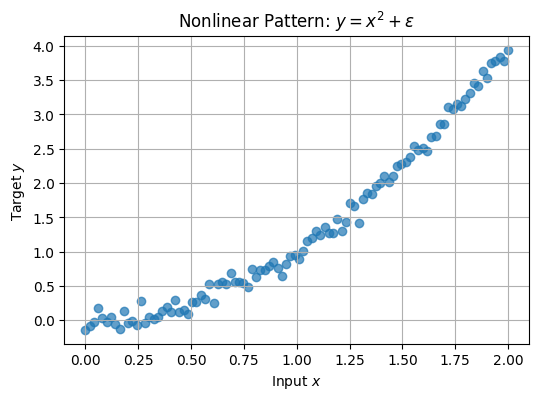

In [2]:
import torch
import matplotlib.pyplot as plt

# Generate input values
x = torch.linspace(0, 2, 100).unsqueeze(1)

# Create nonlinear targets: y = x^2 + small noise
y = x**2 + 0.1 * torch.randn_like(x)

# Plot the data
plt.figure(figsize=(6, 4))
plt.scatter(x.numpy(), y.numpy(), alpha=0.7)
plt.title('Nonlinear Pattern: $y = x^2 + \\epsilon$')  # Or: 'y = x² + noise'
plt.xlabel('Input $x$')
plt.ylabel('Target $y$')
plt.grid(True)
plt.show()


> 📉 The plot above shows a **clear curve**—a parabola.

✅ This is a relationship that a linear model **cannot capture**.  
A line can only go straight—but our data bends. If we tried to fit a straight line here, it would **underfit badly**.

### 🔑 Key Insight

This experiment shows us, visually and intuitively, that:
- **Nonlinear functions** require **nonlinear models**
- A model like $\hat{y} = XW + b$ just doesn’t have enough flexibility

Next, we’ll fix this limitation by adding **nonlinearity** to the model using **activation functions**.

---

## 3. Stacking Linear Layers (Without Activation)

Let’s explore a tempting idea:  
"If a single linear layer can’t fit nonlinear data, maybe we can just **stack two** linear layers?"

At first glance, this seems promising—but we’ll soon see that it doesn’t work.

### Why Stacking Linear Layers Alone Doesn’t Help

Linear transformations have a **key mathematical property**:

> 🔁 **A composition of linear functions is still a linear function.**

So:
$$
\text{Linear}_2(\text{Linear}_1(X)) = XW_1W_2 + b_{\text{combined}}
$$

This is still of the form $\hat{y} = XW + b$

✅ Stacking two (or more) linear layers **without activation functions** does **not increase expressiveness**.  
The model still behaves just like a single linear layer.


### 📦 Schematic: What’s Happening?

```text
    Input X      →  Linear Layer 1 →  Linear Layer 2  →  Output ŷ
    (1 dim)          (1 → 5)           (5 → 1)           (1 dim)

  No activation in between → still just a linear transformation


To prove this empirically, let’s build such a model and test it on the nonlinear data from Section 2.

In [3]:

### 💻 Code Cell

import torch
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)

# Dimensions
input_dim = 1
hidden_dim = 5
output_dim = 1

# Initialize two linear layers
W1 = torch.randn(input_dim, hidden_dim, requires_grad=True)
b1 = torch.randn(hidden_dim, requires_grad=True)
W2 = torch.randn(hidden_dim, output_dim, requires_grad=True)
b2 = torch.randn(output_dim, requires_grad=True)

# Define predict function (no activation)
def predict(X):
    hidden = X @ W1 + b1
    output = hidden @ W2 + b2
    return output

# Make predictions
y_pred = predict(x)


📊 Plotting

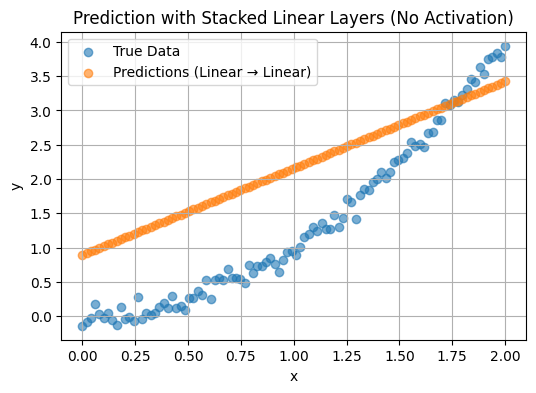

In [4]:
# Plot predictions vs. true nonlinear data
plt.figure(figsize=(6, 4))
plt.scatter(x.numpy(), y.numpy(), label='True Data', alpha=0.6)
plt.scatter(x.numpy(), y_pred.detach().numpy(), label='Predictions (Linear → Linear)', alpha=0.6)
plt.legend()
plt.title('Prediction with Stacked Linear Layers (No Activation)')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()


> ❗ Even though we used two layers, the model still fits a **straight-ish line**.

✅ This visual proof shows:
- Stacking linear layers without activation **doesn’t increase model capacity**
- We still can't capture the **curved shape** of the data

> 🧠 Key Learning:
To unlock nonlinear patterns, we need to add **nonlinearity** between layers.

And that’s exactly what **activation functions** are for.

Next, we’ll explore what they are and how they help.


### 🔍 What This Plot Shows Us

In the chart above:

- The **blue points** represent our synthetic data: $y = x^2 + \text{noise}$
- The **orange points** are predictions from the model: two linear layers **without** any activation in between


### 🧠 Interpretation

Even with two layers, the model:
- Fails to capture the curve
- Predicts a nearly straight line through the middle of the data
- **Underfits** the nonlinear pattern

✅ This is strong **empirical proof** that stacking linear layers **without activation functions** doesn't help.  
It still acts like a **plain linear model**.

> ⚠️ The model is fundamentally limited in what it can represent—because it has no way to bend!

Next, we’ll learn how to break through this limitation by introducing **nonlinearity** through **activation functions**.

---


## 4. Activation Functions — Concept and Examples

In the previous section, we saw that stacking linear layers alone doesn’t help—because the entire model remains linear.

To give our models **nonlinear expressive power**, we need a way to bend and shape the learned function.

This is the role of **activation functions**.


### What Is an Activation Function?

An **activation function** is a nonlinear transformation applied to the output of a neuron (or layer).

$$
\text{Linear Output} \quad \xrightarrow{\text{Activation}} \quad \text{Nonlinear Output}
$$

✅ This is the critical step that allows neural networks to:
- Model **curves, interactions, and complexity**
- Solve tasks like image classification, speech recognition, and natural language processing

Without activation functions, **a neural network is just a linear regression model in disguise**.


### Common Activation Functions

Let’s explore three popular activation functions:

### 🔹 ReLU (Rectified Linear Unit)

**Formula:** $f(x) = \max(0, x)$

- Outputs zero if $x < 0$, and $x$ otherwise  
- Very simple and efficient  
- Helps combat the vanishing gradient problem


### 🔹 Sigmoid

**Formula:** $f(x) = \frac{1}{1 + e^{-x}}$

- Squeezes output between **0 and 1**  
- Often used in binary classification problems  
- Can saturate and cause gradients to vanish


### 🔹 Tanh (Hyperbolic Tangent)

**Formula:** $f(x) = \tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$

- Squeezes output between **-1 and 1**  
- Like sigmoid, but **centered at 0**, which often helps training


Each of these functions introduces **nonlinearity**, enabling neural nets to **stack and compose** complex feature transformations.


💻 Plot the Activation Functions

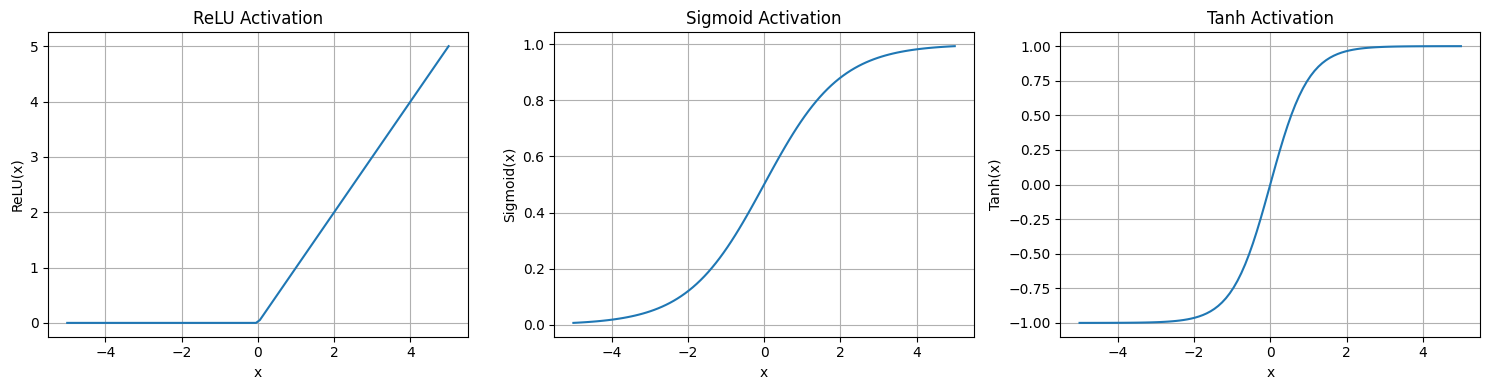

In [5]:
import torch
import matplotlib.pyplot as plt

# Create a range of x values
x_vals = torch.linspace(-5, 5, 100)

# Compute outputs
relu = torch.relu(x_vals)
sigmoid = torch.sigmoid(x_vals)
tanh = torch.tanh(x_vals)

# Plot all three functions
plt.figure(figsize=(15, 4))

# ReLU
plt.subplot(1, 3, 1)
plt.plot(x_vals.numpy(), relu.numpy())
plt.title('ReLU Activation')
plt.xlabel('x')
plt.ylabel('ReLU(x)')
plt.grid(True)

# Sigmoid
plt.subplot(1, 3, 2)
plt.plot(x_vals.numpy(), sigmoid.numpy())
plt.title('Sigmoid Activation')
plt.xlabel('x')
plt.ylabel('Sigmoid(x)')
plt.grid(True)

# Tanh
plt.subplot(1, 3, 3)
plt.plot(x_vals.numpy(), tanh.numpy())
plt.title('Tanh Activation')
plt.xlabel('x')
plt.ylabel('Tanh(x)')
plt.grid(True)

plt.tight_layout()
plt.show()


### Interpreting the Activation Curves

These plots show the **shape** of each function:

| Function | Range       | Shape Summary                       |
|----------|-------------|-------------------------------------|
| ReLU     | $[0, \infty)$ | Flat for $x<0$, linear for $x>0$     |
| Sigmoid  | $(0, 1)$     | S-curve, flattens at both ends     |
| Tanh     | $(-1, 1)$    | S-curve centered around zero       |

✅ Each curve **bends the output**, allowing the network to **model nonlinear mappings**.

Next, we’ll build a simple network with an activation function in the middle and see how it learns a **nonlinear pattern**.

---


## 5. Implementing Activation Functions (Manually)

We’ve seen that activation functions play a critical role in neural networks.

PyTorch provides built-in versions of ReLU, Sigmoid, and Tanh.  
But to **build intuition**, let’s write simplified versions of them ourselves.

This helps us understand:
- What these functions do mathematically
- How they behave on tensors
- Why their shapes matter during training

We’ll start with **ReLU** and **Sigmoid**.


### ReLU (Rectified Linear Unit)

Let’s implement the ReLU function manually.

**Formula:** $f(x) = \max(0, x)$

In plain terms:
- If $x > 0$: output is $x$
- If $x \leq 0$: output is 0

✅ ReLU introduces **sparsity** and helps combat the **vanishing gradient** problem common in sigmoid/tanh.

Let’s now implement this logic step-by-step.


💻 Code Cell: Manual ReLU

In [6]:
import torch

# Define ReLU manually
def my_relu(x):
    return torch.clamp(x, min=0)

# Test on a sample tensor
test_x = torch.tensor([-2.0, -1.0, 0.0, 1.0, 2.0])
print("Input:", test_x)
print("ReLU Output:", my_relu(test_x))


Input: tensor([-2., -1.,  0.,  1.,  2.])
ReLU Output: tensor([0., 0., 0., 1., 2.])



This confirms that:
- All negative values are converted to 0
- Positive values are passed through unchanged


### Sigmoid Function

Now let’s manually implement the **sigmoid function**.


**Formula:**

$$
f(x) = \frac{1}{1 + e^{-x}}
$$

This function:
- Compresses values into the range **(0, 1)**
- Is useful for tasks like binary classification
- Has an S-shaped curve

Let’s now implement this using tensor operations.


In [7]:
# Define Sigmoid manually
def my_sigmoid(x):
    return 1 / (1 + torch.exp(-x))

# Test
test_x = torch.tensor([-2.0, -1.0, 0.0, 1.0, 2.0])
print("Input:", test_x)
print("Sigmoid Output:", my_sigmoid(test_x))


Input: tensor([-2., -1.,  0.,  1.,  2.])
Sigmoid Output: tensor([0.1192, 0.2689, 0.5000, 0.7311, 0.8808])



This confirms:
- Values < 0 are squeezed toward 0
- Values > 0 are squeezed toward 1
- The midpoint (0) maps to 0.5

We’ve now manually constructed and tested **two key activation functions**.

Next, we’ll use one of these inside a real mini-network to learn nonlinear patterns.

---

## 6. Building Neural Networks (Manual)

Let’s now **build two small neural networks by hand**:


### 🔹 Model A: Linear → Linear (No Activation)

- Composed of two stacked linear transformations
- No nonlinearity
- Still behaves like a simple linear model


### 🔹 Model B: Linear → ReLU → Linear

- Adds a **nonlinear activation (ReLU)** between layers
- Can capture curved patterns


We’ll manually initialize weights, define forward passes, and visualize predictions.

No use of `nn.Module` or `Sequential` — everything is built from **first principles**.


### Model A: Linear → Linear (No Activation)

We begin with a basic two-layer model with **no activation function** between the layers:

```text
    x  →  Linear Layer 1  →  Linear Layer 2  →  ŷ
    (1)     (1 → 5)             (5 → 1)
```
Even though there are two layers, because we don’t use an activation function, the overall transformation is still linear.

Let’s implement this model now.

💻 Model A (No Activation)

In [8]:
import torch

# Set random seed for reproducibility
torch.manual_seed(42)

# Define dimensions
input_dim = 1
hidden_dim = 5
output_dim = 1

# Initialize parameters
W1_lin = torch.randn(input_dim, hidden_dim, requires_grad=True)
b1_lin = torch.randn(hidden_dim, requires_grad=True)
W2_lin = torch.randn(hidden_dim, output_dim, requires_grad=True)
b2_lin = torch.randn(output_dim, requires_grad=True)

# Define the prediction function (no activation)
def predict_linear(X):
    hidden = X @ W1_lin + b1_lin
    output = hidden @ W2_lin + b2_lin
    return output

# Predict on synthetic x
y_pred_lin = predict_linear(x)


✅ This model applies two back-to-back linear transformations with no activation.

> Even with two layers, this model behaves **just like a single linear transformation**:
> $$ \hat{y} = XW + b $$

We expect it to underfit the **nonlinear data** from Section 2.


### Model B: Linear → ReLU → Linear

Now we’ll build a similar two-layer network, but insert a **ReLU activation function** between the layers:

```text
    x  →  Linear Layer 1  →  ReLU  →  Linear Layer 2  →  ŷ
    (1)     (1 → 5)              |        (5 → 1)
```

This small change makes a huge difference:
The model can now fit nonlinear curves like our $y = x^2$ toy dataset.

Let’s implement this version below.

💻 Model B (With ReLU)

In [9]:

# Reuse same dimensions
torch.manual_seed(42)

# Initialize new parameters for ReLU model
W1_relu = torch.randn(input_dim, hidden_dim, requires_grad=True)
b1_relu = torch.randn(hidden_dim, requires_grad=True)
W2_relu = torch.randn(hidden_dim, output_dim, requires_grad=True)
b2_relu = torch.randn(output_dim, requires_grad=True)

# Define your ReLU function if not already
def my_relu(x):
    return torch.clamp(x, min=0)

# Define prediction function with activation
def predict_relu(X):
    hidden = my_relu(X @ W1_relu + b1_relu)
    output = hidden @ W2_relu + b2_relu
    return output

# Predict
y_pred_relu = predict_relu(x)

✅ This model has **one hidden layer** followed by **ReLU** before the final output layer.

Now the network is capable of **curving** and **bending** its prediction surface.

This is a **true nonlinear model**, and we expect it to perform **better** than Model A on our data.

> Up next: We’ll visualize the predictions from both models side-by-side to compare their performance.

---


## 7. Training and Comparing the Models

Let’s now **train both networks** — the one without activation, and the one with ReLU — on our nonlinear dataset.

### 🔍 What Are We Testing?

| Model                     | Structure                  | Expected Behavior                      |
|--------------------------|----------------------------|----------------------------------------|
| Linear → Linear           | No nonlinearity            | Limited to straight-line fits          |
| Linear → ReLU → Linear    | Includes activation        | Can curve and adapt to nonlinearity    |


We’ll use **Mean Squared Error (MSE)** as the loss,  
train both models for **3,000 epochs**,  
and **plot their learning curves** side-by-side.

This will help us **visually confirm** the power of activation functions.


💻 MSE Loss Definition

In [10]:
# Define MSE loss function
def mse_loss(preds, targets):
    return ((preds - targets)**2).mean()


💻 Training Loop for Both Models

In [11]:
# Set learning rate and number of epochs
lr = 0.01
epochs = 3000

# Store training losses
losses_linear = []
losses_relu = []

for epoch in range(epochs):
    
    # ===== Linear → Linear =====
    preds_lin = predict_linear(x)
    loss_lin = mse_loss(preds_lin, y)
    loss_lin.backward()

    with torch.no_grad():
        W1_lin -= lr * W1_lin.grad
        b1_lin -= lr * b1_lin.grad
        W2_lin -= lr * W2_lin.grad
        b2_lin -= lr * b2_lin.grad
        
        # Zero gradients
        W1_lin.grad.zero_()
        b1_lin.grad.zero_()
        W2_lin.grad.zero_()
        b2_lin.grad.zero_()

    losses_linear.append(loss_lin.item())

    # ===== Linear → ReLU → Linear =====
    preds_relu = predict_relu(x)
    loss_relu = mse_loss(preds_relu, y)
    loss_relu.backward()

    with torch.no_grad():
        W1_relu -= lr * W1_relu.grad
        b1_relu -= lr * b1_relu.grad
        W2_relu -= lr * W2_relu.grad
        b2_relu -= lr * b2_relu.grad

        W1_relu.grad.zero_()
        b1_relu.grad.zero_()
        W2_relu.grad.zero_()
        b2_relu.grad.zero_()

    losses_relu.append(loss_relu.item())


💻 Plotting Loss Curves

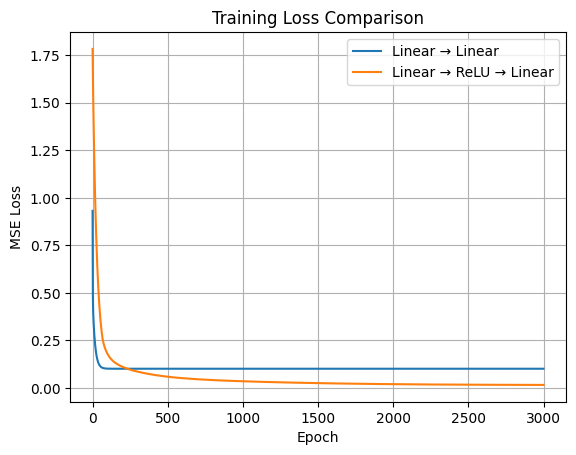

In [13]:
import matplotlib.pyplot as plt

plt.plot(losses_linear, label='Linear → Linear')
plt.plot(losses_relu, label='Linear → ReLU → Linear')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.grid(True)
plt.show()


### What This Plot Tells Us

- The **blue line** shows the loss for the model without activation.
- The **orange line** is for the model with ReLU in the middle.

### 🔍 Key Observations:

- Both models start with a high loss and gradually reduce it.
- The **ReLU model converges to a significantly lower loss**.
- The **Linear → Linear model flattens out early**, unable to capture the curve in the data.

✅ This confirms what we suspected:
> Without activation, a network **cannot represent nonlinear relationships** — no matter how many linear layers we stack.

Next, let’s plot the **final predictions** from each model and compare them directly to the true data.

---


## 8. Visualizing Predictions from Both Models

Let’s now visually compare what our models have learned.

### 🔍 What Are We Looking For?

We want to overlay each model’s predicted curve on top of the **true data points** to visually assess performance:

| Model                     | Expectation                                      |
|--------------------------|--------------------------------------------------|
| Linear → Linear           | Straight-line prediction; poor fit for a curve  |
| Linear → ReLU → Linear    | Curved prediction; fits the parabola better     |


This side-by-side comparison provides **visual intuition** to support our earlier loss curve findings.

> ✅ Sometimes, a plot reveals what numbers alone can’t.


💻 Predictions and Sorting

In [12]:
# Predict outputs using final trained models
y_pred_lin = predict_linear(x).detach()
y_pred_relu = predict_relu(x).detach()

# Sort for smooth plotting
sorted_idx = torch.argsort(x.squeeze())

x_sorted = x.squeeze()[sorted_idx]
y_sorted_true = y.squeeze()[sorted_idx]
y_sorted_lin = y_pred_lin.squeeze()[sorted_idx]
y_sorted_relu = y_pred_relu.squeeze()[sorted_idx]


💻 Two-Panel Plot

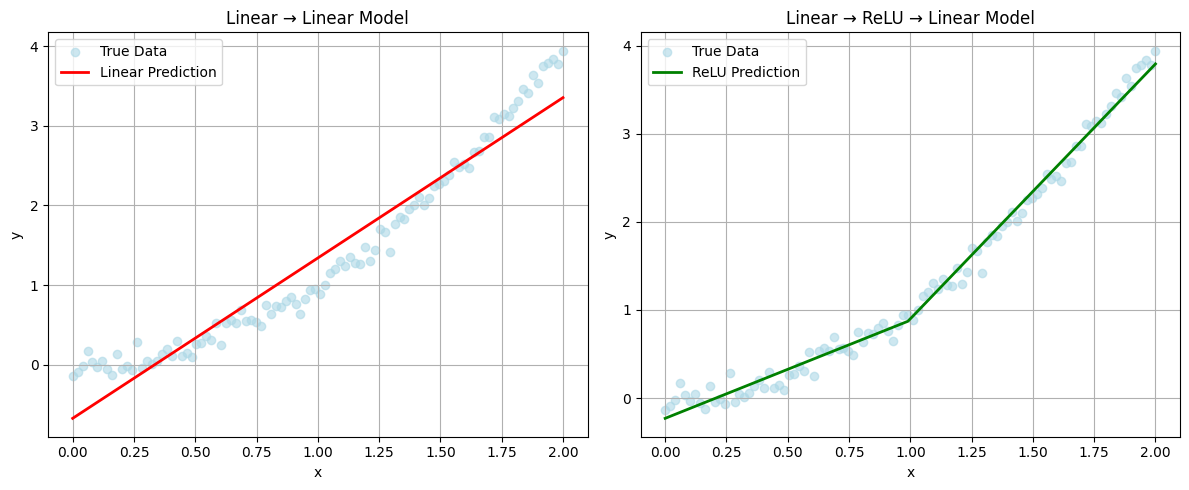

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Subplot 1 — Linear ➔ Linear
plt.subplot(1, 2, 1)
plt.scatter(x_sorted.numpy(), y_sorted_true.numpy(), color='lightblue', label='True Data', alpha=0.6)
plt.plot(x_sorted.numpy(), y_sorted_lin.numpy(), color='red', label='Linear Prediction', linewidth=2)
plt.title('Linear → Linear Model')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)

# Subplot 2 — Linear ➔ ReLU ➔ Linear
plt.subplot(1, 2, 2)
plt.scatter(x_sorted.numpy(), y_sorted_true.numpy(), color='lightblue', label='True Data', alpha=0.6)
plt.plot(x_sorted.numpy(), y_sorted_relu.numpy(), color='green', label='ReLU Prediction', linewidth=2)
plt.title('Linear → ReLU → Linear Model')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### What the Plots Show Us

Let’s interpret the outcome:

---

🔴 **Model A: Linear → Linear**

- Predicts a **straight line**.
- Cannot bend to follow the curved data.
- This leads to **systematic errors**, especially at the extremes.

---

🟢 **Model B: Linear → ReLU → Linear**

- Captures the **nonlinear shape** more accurately.
- Clearly bends to match the **quadratic pattern** in the data.
- Has **learned the underlying function** better.

✅ This confirms:  
> A **nonlinear activation function (like ReLU)** is essential for learning **nonlinear patterns**.


This experiment mirrors a fundamental idea in deep learning:
> **Nonlinearity is what gives neural networks their power.**

---


## 9. Why Nonlinearity Matters — Final Reflection

In this notebook, we took our first major step **beyond linear models**.

By:
- Visualizing curved patterns
- Stacking layers with and without activations
- Manually training and comparing two models

…we **proved to ourselves** that non-linearity is not just helpful — it's essential.


### 🔍 Why ReLU Made a Difference

Without ReLU, our model behaved like a line — no matter how many layers we stacked.

With ReLU, we gave the network the **power to bend** its predictions to match the data.  
This simple activation opened the door to **nonlinear decision boundaries** — which are everywhere in real-world data.


### 🔮 What's Coming in Notebook 4

We’ve only scratched the surface.

In the next notebook, we will:

- Build a real **Multi-Layer Perceptron (MLP)** using PyTorch’s `nn.Module`
- Learn about **hidden layers**, **modular design**, and **training with `torch.optim`**
- Train on the **Concrete Strength dataset** with all **8 input features**
- Start developing models that generalize beyond toy data

> 🎓 We’re moving from **manual neurons** to **scalable neural networks**.


✅ Takeaway:

This notebook showed **why** deep learning works.  
In the next one, we’ll begin to build networks that can actually tackle **real regression tasks** with confidence.

Let’s go from **lines and curves** to **layers and capacity**!
